<a href="https://colab.research.google.com/github/themoonwalker1/quantcap-options/blob/main/options_data_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Quant Cap Options Trading 23/24

In [3]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import json
import httpx
import csv
import zstandard as zstd
import io
import yfinance as yf
from dateutil.relativedelta import relativedelta
from httpx import HTTPStatusError
import seaborn as sns
import matplotlib.pyplot as plt
import os.path as osp
import pickle
from pathlib import Path
import glob
# import pandas_ta as ta

In [4]:
# my_data = GatherData()

# df = my_data.get_historical_data(['GOOGL'], '2024-01-01','2025-01-01')
# print(df)

In [5]:
class GatherData():
    
    def get_historical_data(self, symbols: list[str], start_date: str, end_date: str, save_to_csv: bool = True) -> pd.DataFrame:
        """
       
        Pulls EOD Options, EOD Greeks, and Open Interest data from ThetaData API and returns it as a DataFrame
         
        Retrieves data pertaining to the given parameters (params) from the
        historical option and Greeks EOD and Open Interest endpoints. The data
        includes all possible expiration dates and strike prices within the
        specified range. Reference: https://http-docs.thetadata.us/

        Args:
            symbols: A list of strings representing the tickers to fetch historical option data.
            start_date: A string representing the start date for historical option data
            end_date: A string representing the end date for the historical option data
            save_to_csv: A boolean for whether to save the dataframe as a csv file


        Returns:
            merged_df: A combined Pandas DataFrame of historical option EOD, historical Greeks EOD, and Open Interest data


        Raises:
            HTTPError: If the API request fails.
            ValueError: If the response data is not in the expected format.
        """
        
        # Finding and pulling the relevant data file
        file_path = f'historical_data_{"_".join(symbols)}_{start_date}-{end_date}.csv.zst'
        if Path('../Quantcap-Options/' + file_path).exists():
            return self.zst_to_dataframe('../Quantcap-Options/' + file_path, delimiter=',')
        
        start_date_parsed = datetime.strptime(start_date, "%Y-%m-%d")
        end_date_parsed = datetime.strptime(end_date, "%Y-%m-%d")

        # If the exact file path isn't found with the start and end dates, 
        # pull the relevant data from another data file of the same ticker
        pattern = f'historical_data_{"_".join(symbols)}_*.csv.zst'
        files = glob.glob('../Quantcap-Options/' + pattern)
        if files:
            for path in files:
                if Path(path).exists():
                    df = self.zst_to_dataframe(path, delimiter=',')
                    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce')
                    df['expiration'] = pd.to_datetime(df['expiration'], format='%Y-%m-%d', errors='coerce')
                    return df[(df['date'] >= start_date_parsed) & (df['date'] <= end_date_parsed)]
                    

        # BASE_URL = "http://127.0.0.1:25510/v2"
        BASE_URL = "http://127.0.0.1:25512/v2"

        tot_data = []
        oi_data = []

        header_eod = None
        header_oi = None
        for symbol in symbols:
            current_date = start_date_parsed
            while current_date <= end_date_parsed:              
                params = {
                    "root": symbol,
                    "start_date": current_date.strftime("%Y%m%d"),
                    "end_date": current_date.strftime("%Y%m%d"),
                    "exp": 0,
                    "use_csv": 'true'
                }

                urleod = BASE_URL + '/bulk_hist/option/eod_greeks'

                header = None
                while urleod is not None:
                    try:
                        response = httpx.get(urleod, params=params)
                        response.raise_for_status()
                        csv_data = csv.reader(response.text.split("\n"))
                        if header is None:
                            header = next(csv_data)
                            if header_eod is None:
                                header_eod = header
                                expiration_idx_eod = header_eod.index('expiration')
                                tot_data.append(header_eod)
               
                        for line in csv_data:
                            if line:
                                if True:
                                    expiration_date = datetime.strptime(line[expiration_idx_eod], '%Y%m%d')
                                    date_diff = (expiration_date - current_date).days
                                    if 0 <= date_diff <= 30:
                                        tot_data.append(line)
                               
                        if 'Next-Page' in response.headers and response.headers['Next-Page'] != "null":
                            urleod = response.headers['Next-Page']
                        else:
                            urleod = None
                    except HTTPStatusError as e:
                        if e.response.status_code == 472:
                            print(f"No results for {symbol} on {current_date.strftime('%Y-%m-%d')} for EOD Greeks, skipping.")
                            break
                        else:
                            raise

                urloi = BASE_URL + '/bulk_hist/option/open_interest'

                header = None
                while urloi is not None:
                    try:
                        response = httpx.get(urloi, params=params)
                        response.raise_for_status()
                        csv_data = csv.reader(response.text.split("\n"))
                        if header is None:
                            header = next(csv_data)
                            if header_oi is None:
                                header_oi = header
                                expiration_idx_oi = header_oi.index('expiration')
                                oi_data.append(header_oi)
                        for line in csv_data:
                            if line:
                                if True:
                                    expiration_date = datetime.strptime(line[expiration_idx_oi], '%Y%m%d')
                                    date_diff = (expiration_date - current_date).days
                                    if 0 <= date_diff <= 30:
                                        oi_data.append(line)
                                       
                        if 'Next-Page' in response.headers and response.headers['Next-Page'] != "null":
                            urloi = response.headers['Next-Page']
                        else:
                            urloi = None
                    except HTTPStatusError as e:
                        if e.response.status_code == 472:
                            print(f"No results for {symbol} on {current_date.strftime('%Y-%m-%d')} for Open Interest, skipping.")
                            break
                        else:
                            raise  
                current_date += timedelta(days=1)

        def process(data):
            df = pd.DataFrame(data)
            df.columns = df.iloc[0]
            df = df.drop(0).reset_index(drop=True)
            df['expiration'] = pd.to_datetime(df['expiration'], format='%Y%m%d', errors='coerce')
            if df['expiration'].isnull().any():
                print("Warning: Some 'expiration' values could not be parsed and were set to NaT.")
            df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='coerce')
            if df['date'].isnull().any():
                print("Warning: Some 'date' values could not be parsed and were set to NaT.")
            return df
        df_eod = process(tot_data)
        df_oi = process(oi_data)

        df_merged = pd.merge(df_eod, df_oi, on=['root', 'expiration', 'strike', 'right', 'date'], how='left')

        df_merged = df_merged[['date', 'root', 'expiration', 'strike', 'right', 'close', 'volume', 'count',
                               'bid', 'bid_size', 'ask', 'ask_size', 'open_interest', 'delta', 'theta', 'vega', 'rho',
                               'epsilon', 'lambda', 'gamma', 'd1', 'd2', 'implied_vol', 'iv_error', 'underlying_price']]

        df_merged = df_merged.rename(columns={'root': 'ticker'})
        df_merged["date"] = pd.to_datetime(df_merged["date"]).dt.date

        if save_to_csv:
            df_merged.to_csv(file_path, index=False)

        return df_merged



    def get_sentiment_data(self, symbols: list[str], start_date: str, end_date: str, interval: str = "1d") -> pd.DataFrame:
        """
        Fetch sentiment data from StockGeist API and return it as a DataFrame.

        This function retrieves sentiment data for a specified asset class and
        location from the StockGeist API. The data includes both message and
        article sentiment metrics for a given symbol over a specified date range.
        Reference: https://docs.stockgeist.ai/

        Args:
            symbols: A list of strings representing the tickers to fetch sentiment data for.
                eg: ["AAPL", "MSFT", "GOOGL"]
            start_date: A string representing the start date for the sentiment data.
            end_date: A string representing the end date for the sentiment data.
            interval: A string representing the interval for the sentiment data.
        Returns:
            DataFrame: A pandas DataFrame containing the sentiment data.

        Raises:
            HTTPError: If the API request fails.
            ValueError: If the response data is not in the expected format.
        """

        # constants
       

        # API Key
        STOCKGEIST_API_KEY = 'b2s0InjGYj5JJN5SvLf2gWjiAorevDVd'
        headers = {"token": STOCKGEIST_API_KEY}

        # API endpoint
        base_url = "https://api.stockgeist.ai"
        asset_class = "stock"  # or "crypto"
        location = "us"  # or "global"

        # Messages sentiment data
        messages_url = f"{base_url}/{asset_class}/{location}/hist/message-metrics"
        messages_params = {
            "symbols": ','.join(symbols),
            "start": start_date,
            "end": end_date,
            "timeframe": interval
        }
        
        messages_data = None
        if osp.exists("sentiment_data_messages.json"):
            with open("sentiment_data_messages.json", "r") as f:
                messages_data = json.load(f)
        else:
            response = requests.get(messages_url, headers=headers, params=messages_params)
            if response.status_code != 200:
                raise requests.HTTPError(f"{response.status_code}: {response.text}")
            messages_data = response.json().get("data", {})
            with open("sentiment_data_messages.json", "w") as f:
                json.dump(messages_data, f)
            

        messages_date_rows = []
        for symbol in symbols: # same stocks in symbols
            stock_data = messages_data.get(symbol, [])
            for day_data in stock_data:
                date = datetime.fromisoformat(day_data.get("timestamp")).date() # date only
                pos_em_count = day_data.get("pos_em_count", 0)
                pos_nem_count = day_data.get("pos_nem_count", 0)
                neu_em_count = day_data.get("neu_em_count", 0)
                neu_nem_count = day_data.get("neu_nem_count", 0)
                neg_em_count = day_data.get("neg_em_count", 0)
                neg_nem_count = day_data.get("neg_nem_count", 0)
                em_total_count = day_data.get("em_total_count", 0)
                nem_total_count = day_data.get("nem_total_count", 0)
                pos_total_count = day_data.get("pos_total_count", 0)
                neu_total_count = day_data.get("neu_total_count", 0)
                neg_total_count = day_data.get("neg_total_count", 0)
                total_count = day_data.get("total_count", 0)

                # calculate message sentiment using custom formula
                #normalized: 0 to 1
                # message_sentiment = EM_WEIGHT * (pos_em_count + neg_em_count) / em_total_count + NEM_WEIGHT * (pos_nem_count + neg_nem_count) / nem_total_count
                # messages_date_rows.append([symbol, date, message_sentiment])
                messages_date_rows.append([symbol, date, pos_em_count, neg_em_count, em_total_count, pos_nem_count, neu_em_count, neu_nem_count, neg_nem_count, nem_total_count, pos_total_count, neu_total_count, neg_total_count, total_count])

        messages_df = pd.DataFrame(messages_date_rows, columns=["ticker", "date", "pos_em_count", "neg_em_count", "em_total_count", "pos_nem_count", "neu_em_count", "neu_nem_count", "neg_nem_count", "nem_total_count", "pos_total_count", "neu_total_count", "neg_total_count", "total_count"])

        # Articles sentiment data
        articles_url = f"{base_url}/{asset_class}/{location}/hist/article-metrics"
        articles_params = {
            "symbols": ','.join(symbols),
            "start": start_date,
            "end": end_date,
            "timeframe": interval,
            "max_symbol_articles": 200,
            "sort_by": "timestamp"
        }

        articles_data = None
        if osp.exists("sentiment_data_articles.json"):
            with open("sentiment_data_articles.json", "r") as f:
                articles_data = json.load(f)
        else:
            response = requests.get(articles_url, headers=headers, params=articles_params)
            if response.status_code != 200:
                raise requests.HTTPError(f"{response.status_code}: {response.text}")
            articles_data = response.json().get("data", {})
            with open("sentiment_data_articles.json", "w") as f:
                json.dump(articles_data, f)

        articles_date_rows = []
        for symbol in symbols:
            stock_data = articles_data.get(symbol, [])  
            for day_data in stock_data:
                date = datetime.fromisoformat(day_data.get("timestamp")).date() # date only
                mentions = day_data.get("mentions", 0)
                title_sentiment = day_data.get("title_sentiment", "neutral")
                sentiment_map = {"neutral": 0, "positive": 1, "negative": -1} # # neutral, positive, negative
                title_sentiment = sentiment_map.get(title_sentiment, 0)
                # ignore title, summary, original_url, img_url, sentiment_spans

                # calculate article sentiment using custom formula
                article_sentiment = title_sentiment * mentions  

                articles_date_rows.append([symbol, date, article_sentiment, mentions])

        # symbol/date pair should be unique
        articles_df = pd.DataFrame(articles_date_rows, columns=["ticker", "date", "article_sentiment", "article_count"]).groupby(['ticker', 'date'], as_index=False)[['article_sentiment', 'article_count']].sum()


        # combine messages and articles dataframes
        sentiment_df = pd.merge(messages_df, articles_df, on=["ticker", "date"], how="outer")
        sentiment_df.fillna(0, inplace=True)
        sentiment_df["date"] = pd.to_datetime(sentiment_df["date"]).dt.date
        # sentiment_df.set_index(["symbol", "date"], inplace=True)

        # calculate weighted sentiment
        # sentiment_df["weighted_sentiment"] = MESSAGE_WEIGHT * sentiment_df["message_sentiment"] + ARTICLE_WEIGHT * sentiment_df["article_sentiment"]

        return sentiment_df


    def get_fundamental_data(self, ticker: str, start_date: str, end_date: str):
        """ 
        Pulls historical stock data from Tiingo using its API and 
        preprocesses it by getting the percentage stock increase per 
        week from the raw EOD close data

        Args: 
            ticker: A string with the specified stock ticker
            start_date: Starting date of the data returned
            end_date: End date of the data returned
        Returns: 
            Pandas Dataframe with two columns: the date and the percentage stock increase a week out into the future. 
            The date is an integer in the form YYYY-MM-DD, and the percentage stock increase is a float. 
        Raises: 
            ValueError if the total_years inputted are greater than 30. 
        """
        file_name = "fundamental"
        cur_path = osp.dirname(osp.abspath("__file__"))
        path_to_file = osp.join(cur_path, '{}.pickle'.format(file_name))
        to_return = None
        if osp.isfile(path_to_file):
            to_return = pickle.load(open(path_to_file, 'rb'))[0]
        else:
            TIINGO_API_KEY = '95b8e93dadad1cceda98479bc2420f9a0bb5556a'
            base_url = "https://api.tiingo.com/tiingo/daily"
            url = f"{base_url}/{ticker.lower()}/prices?startDate={start_date}&endDate={end_date}&token={TIINGO_API_KEY}"
            headers = {
                'Content-Type': 'application/json'
            }
            requestResponse = requests.get(url, headers=headers)
            requestResponse = requestResponse.json()
            # print(requestResponse)
            # size = len(requestResponse)
            # to_return = {"date": [None] * size, "pct_change": np.ndarray((size))}
            # for i in range(7, len(requestResponse)):
            #     entry = requestResponse[i]
            #     temp_date = entry["date"]
            #     end_date = datetime.fromisoformat(temp_date[:-1] + '+00:00') - relativedelta(days=7)
            #     end_date = end_date.isoformat()[:-6] + '.000Z'
            #     match_close = [a['close'] for a in requestResponse if a['date']== end_date]
            #     if len(match_close) != 0:
            #         day = temp_date[:10]
            #         close_1 = entry['close']
            #         close_2 = match_close[0]
            #         pct_change = (close_1 - close_2) / close_2 * 100
            #         to_return["date"][i] = day
            #         to_return["pct_change"][i] = pct_change
            #     indices_of_none_dates = [x for x in range(len(to_return["date"])) if to_return["date"][x] is not None]
            #     to_return["date"] = [to_return["date"][x] for x in indices_of_none_dates]
            #     to_return["pct_change"] = [to_return["pct_change"][x] for x in indices_of_none_dates]
            to_return = pd.json_normalize(requestResponse)
            to_return["ticker"] = ticker
            to_return["date"] = pd.to_datetime(to_return["date"]).dt.date
            with open(path_to_file, 'wb') as cachedfile:
                pickle.dump((to_return,), cachedfile)
        return to_return


    def zst_to_dataframe(self, file_path, delimiter=','):
        """
        Converts a Zstandard-compressed file (.zst) to a pandas DataFrame.

        Args:
            file_path (str): Path to the .zst file.
            delimiter (str): Delimiter used in the CSV file (default is ',').

        Returns:
            pd.DataFrame: The resulting pandas DataFrame.
        """
        with open(file_path, 'rb') as f:
                # Create a Zstandard decompressor
                dctx = zstd.ZstdDecompressor()

                # Decompress the file using a streaming reader
                with dctx.stream_reader(f) as reader:
                    # Wrap the decompressed data into a text wrapper
                    decompressed_data = io.TextIOWrapper(reader, encoding='utf-8')
                    
                    # Read the decompressed data into a DataFrame
                    df = pd.read_csv(decompressed_data, delimiter=delimiter)
        return df




    def shrink_dataframe(df, fields_to_keep):
        """
        Reduces a DataFrame to only the specified fields (columns).

        Args:
            df (pd.DataFrame): The original DataFrame.
            fields_to_keep (list): List of column names to retain.

        Returns:
            pd.DataFrame: A reduced DataFrame containing only the specified fields.
        """
        # Check if all fields to keep are in the DataFrame
        missing_fields = [field for field in fields_to_keep if field not in df.columns]
        if missing_fields:
            raise ValueError(f"The following fields are not in the DataFrame: {missing_fields}")

        # Keep only the specified columns
        reduced_df = df[fields_to_keep]
        return reduced_df
    
        # Original file was >7GB thus most processing was done beforehand by code in 13F_parser.ipynb. institutional_data.csv is already cleaned.

    def get_institutional_data(self, input_path, symbols: list[str], start_date: str, end_date: str) -> pd.DataFrame:
        """
        Reads institutional data from a CSV file, filters it by symbols and date range,
        and returns a DataFrame.

        Args:
            input_path (str): Path to the input CSV file.
            symbols (list[str]): List of tickers to filter the data for.
            start_date (str): Start date (inclusive) in "YYYY-MM-DD" format.
            end_date (str): End date (inclusive) in "YYYY-MM-DD" format.

        Returns:
            pd.DataFrame: A DataFrame containing the filtered institutional data.
        """
        # Read the input CSV file
        df = pd.read_csv(input_path, dtype=str)

        # Ensure the 'date' column is properly converted to datetime
        if "date" not in df.columns:
            raise ValueError("The input CSV is missing a 'date' column.")
        
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        df.dropna(subset=["date"], inplace=True)  # Remove rows with invalid dates

        # Filter by date range
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        
        df = df[(df["date"] >= start_date) & (df["date"] <= end_date)]

        # Filter data by symbols
        if "Ticker" not in df.columns:
            raise ValueError("The input CSV is missing a 'Ticker' column.")
        
        df = df[df["FILINGMANAGER_NAME"].isin(symbols)]

        df.columns = df.columns.str.lower()

        df["date"] = pd.to_datetime(df["date"]).dt.date

        # Return the filtered DataFrame
        return df

    def get_earnings_data(self, symbols: list[str], start_date: str, end_date: str):
        """
        Fetch earnings data from Yahoo Calendar and return it as a DataFrame.

        This function retrieves earnings data for a specified list of tickers
        from the Yahoo Calendar API. The data includes earnings dates and other
        relevant financial information for the given tickers over a specified date range.
        Reference:  https://pypi.org/project/yfinance/
                    https://ranaroussi.github.io/yfinance/index.html    

        Args:
            symbols: A list of strings representing the tickers to fetch earnings data for.
                eg: ["AAPL", "MSFT", "GOOGL"]
            start_date: A string representing the start date for the earnings data.
            end_date: A string representing the end date for the earnings data.

        Returns:
            DataFrame: A pandas DataFrame containing the earnings data.

        Raises:
            HTTPError: If the API request fails.
            ValueError: If the response data is not in the expected format.
        """
        
        earnings_df = pd.DataFrame(columns=["ticker", "date", "estimated_eps", "reported_eps"])
        for symbol in symbols:
            ticker = yf.Ticker(symbol)
            earning_dates_df = ticker.earnings_dates
            earning_dates_df.drop(columns=["Surprise(%)"], inplace=True)
            earning_dates_df.reset_index(drop=False, inplace=True)
            earning_dates_df.columns= ["date", "estimated_eps", "reported_eps"]
            earning_dates_df["ticker"] = symbol
            earning_dates_df.dropna(inplace=True)
            earnings_df = pd.concat([earnings_df, earning_dates_df], ignore_index=True)
        
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        earnings_df["date"] = pd.to_datetime(earnings_df["date"]).dt.tz_localize(None)
        earnings_df = earnings_df[ (earnings_df["date"] >= start_date) & 
                                    (earnings_df["date"] <= end_date)]
        earnings_df['date'] = pd.to_datetime(earnings_df['date']).dt.date
        return earnings_df

    def get_googl_earnings(self, start_date:str, end_date:str):
        earnings = pd.read_csv("googl_earnings.csv") 
        dates = pd.read_csv("googl_earnings_calendar.csv")
        earnings.drop(columns=["period_end_date"], inplace=True)
        earnings["date"] = dates["date"]
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        earnings["date"] = pd.to_datetime(earnings["date"])
        print(earnings)
        earnings = earnings[ (start_date <= earnings["date"]) & 
                                    (earnings["date"] <= end_date)]
        return earnings

    def json_to_dtf(self):
        """ Parses through response and constructs and returns a dataframe"""
        pass

In [6]:
import csv
from collections import defaultdict
import pandas as pd

class LiquidityDataProcessor:
    def __init__(self, csv_file):
        self.csv_file = csv_file

    def get_liquidity_data(self, symbols, start_date, end_date):
        aggregated_data = defaultdict(lambda: {
            "size": 0, "price_sum": 0, "price_count": 0, "mean_range": defaultdict(float)
        })

        # Read the CSV file
        with open(self.csv_file, mode='r') as file:
            reader = csv.DictReader(file)

            # Filter rows based on conditions and aggregate
            for row in reader:
                if row["symbol"] in symbols:
                    date = row["ts_event"].split('T')[0] if 'T' in row["ts_event"] else row["ts_event"]
                    if start_date <= date <= end_date:
                        side = row["side"]
                        range_type = row["range"]
                        key = (date, side, range_type)

                        aggregated_data[key]["size"] += float(row["size"])
                        aggregated_data[key]["price_sum"] += float(row["price"])
                        aggregated_data[key]["price_count"] += 1

        # Prepare the result as a DataFrame
        data_rows = []
        for (date, side, range_type), data in aggregated_data.items():
            mean_price = data["price_sum"] / data["price_count"]
            rounded_price = self.round_to_nearest_0(mean_price)  # Round to nearest .0 or .5

            data_rows.append({
                "date": date,
                "side": side,
                "range_type": range_type,
                "size": data["size"],
                "price": rounded_price
            })

        # Convert to DataFrame and ensure the date column is datetime
        df = pd.DataFrame(data_rows)
        df["date"] = pd.to_datetime(df["date"])
        return df

    @staticmethod
    def round_to_nearest_0(value):
        """Round a number to the nearest .0"""
        return round(value)

# Example usage
processor = LiquidityDataProcessor("three_liquidity.csv")
liquidity_data = processor.get_liquidity_data(["GOOGL"], "2024-01-10", "2025-01-10")
print(liquidity_data)



           date side        range_type          size  price
0    2024-01-10    A        mean_range  3.146678e+10    142
1    2024-01-10    A  below_mean_range  6.334543e+09    141
2    2024-01-10    A  above_mean_range  5.522727e+09    143
3    2024-01-10    B        mean_range  2.699970e+10    142
4    2024-01-10    B  below_mean_range  5.910482e+09    141
...         ...  ...               ...           ...    ...
2208 2024-12-31    N  below_mean_range  1.611181e+10    189
2209 2024-12-31    N  above_mean_range  1.235348e+10    191
2210 2024-12-31    A        mean_range  3.022999e+10    190
2211 2024-12-31    A  below_mean_range  1.637807e+10    189
2212 2024-12-31    A  above_mean_range  1.680241e+10    191

[2213 rows x 5 columns]


In [7]:
class ProcessData():
    def join_all_datasets(self, arr, methods, on_columns):
        """
        Joins all of the datasets in an array of dataframes (arr) using the
        specified methods in the string array (methods). 
        Methods include full, left, right, inner
        
        Args:
            arr (list): A list of pandas Dataframes to be joined.
            methods (list): A list of strings representing join methods
            on_columns (list): A list of specified column names to join on.
            
        Returns:
            df_joined: The resulting DataFrame after all joins have been completed.
        
        Raises:
            ValueError: If number of Dataframes passed in is less than 2
            ValueError: If number of join methods passed in is not len(arr)-1
            """
        
        if len(arr) < 2:
            raise ValueError("Number of dataframes must be at least 2 to perform a join")
        if  len(methods) != len(arr) -1:
            raise ValueError("Number of join methods must be one less than number of dataframes to join")
        
        df_joined = arr[0].copy()
        for i in range(len(methods)):
            How = methods[i]
            df_to_join= arr[i+1]
            On = on_columns[i]
            df_joined = pd.merge(df_joined, df_to_join, how = How, on = On)
        return df_joined

    """ handle missing NaN values using an approach passed in as a string variable named approach for dataset d. Approaches allowed include one-hot encoding, dropping all rows with NaN, etc."""

    def handle_missing_values(self, approach, dataset):
        pass
    """ Normalize features of dataframe x using sklearn methods using an approach passed in as a string variable approach"""

    def normalize_features(self, x, approach):
        pass

    """ Select target features of x, where the features are given in an array feature list"""

    def select_features(self, dataset, feature_list):
        pass
    """ Splits data into training, validation, and testing """

    def split_data(self, dataset, column, test_size, val_size):
        pass
    """ Deletes rows of data containing outliers above a certain threshold from dataset """

    def handle_outliers(self, dataset, threshold):
        pass
    
    # assuming that the ThetaData terminal is running
    def test_method(self):
        test = GatherData()
        print("Fundamental")
        print(test.get_fundamental_data('AAPL', 5))
        print("Options")
        print(test.get_historical_data(['AAPL'], "20190109", "20240109"))
            

In [8]:
def zst_to_dataframe(file_path, delimiter=','):
    """
    Converts a Zstandard-compressed file (.zst) to a pandas DataFrame.

    Args:
        file_path (str): Path to the .zst file.
        delimiter (str): Delimiter used in the CSV file (default is ',').

    Returns:
        pd.DataFrame: The resulting pandas DataFrame.
    """
    try:
        with open(file_path, 'rb') as f:
            # Create a Zstandard decompressor
            dctx = zstd.ZstdDecompressor()

            # Decompress the file using a streaming reader
            with dctx.stream_reader(f) as reader:
                # Wrap the decompressed data into a text wrapper
                decompressed_data = io.TextIOWrapper(reader, encoding='utf-8')

                # Read the decompressed data into a DataFrame
                df = pd.read_csv(decompressed_data, delimiter=delimiter)

        return df

    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except pd.errors.EmptyDataError:
        print(f"File is empty or corrupt: {file_path}")
    except Exception as e:
        print(f"Error processing .zst file: {e}")

    return None


In [9]:
# Analyzing historical data
def graph_data(df_all): 
    sns.heatmap(df_all.corr()) ## df_all is complete data
    sns.pairplot(df_all)

def get_percent_changes(df):
    df = df.sort_values(by='date')
    df['weekly_pct_change'] = np.nan
    for i in range(1, len(df)):
        current_date = df.iloc[i]['date'] ## change to date collumn name
        current_price = df.iloc[i]['price'] ## change to price collumn name
        week_ago_date = current_date - pd.Timedelta(days=7)
        previous_data = df[df['date'] == week_ago_date]
        if not previous_data.empty:
            previous_price = previous_data.iloc[0]['price'] ## change to price collumn name
            pct_change = ((current_price - previous_price) / previous_price) * 100
            df.at[i, 'weekly_pct_change'] = pct_change
        else:
            df.at[i, 'weekly_pct_change'] = np.nan
    return df

In [10]:
# test code for fundamental data
test = GatherData()
print("[1] getting fundamental data")
fundamental_data = test.get_fundamental_data("GOOGL", "2020-01-01", "2025-01-10")
print("[2] getting historical data")
historical_data = test.get_historical_data(["GOOGL"], "2020-01-01", "2025-01-10")
print("[3] getting liquidity data")
# liquidity_data = test.get_liquidity_data(['GOOGL'],"2024-01-10","2025-01-10")
print("[4] getting institutional data")
institutional_data = test.get_institutional_data("institutional_data.csv", ["GOOGL"], "2022-01-10", "2025-01-10")
print("[5] getting sentiment data")
sentiment_data = test.get_sentiment_data(["GOOGL"], "2025-01-01", "2025-01-10")
print("[6] getting earnings data")
earnings_data = test.get_googl_earnings( "2020-01-01", "2025-01-10")


[1] getting fundamental data
[2] getting historical data
[3] getting liquidity data
[4] getting institutional data
[5] getting sentiment data
[6] getting earnings data
   act_symbol  reported  estimate       date
0       GOOGL     26.29     15.66 2021-04-27
1       GOOGL     27.26     19.89 2021-07-27
2       GOOGL     27.99     23.13 2021-10-26
3       GOOGL     30.69     26.69 2022-02-01
4       GOOGL     24.62     25.70 2022-04-26
5       GOOGL      1.21      1.27 2022-07-26
6       GOOGL      1.06      1.25 2022-10-25
7       GOOGL      1.05      1.14 2023-02-02
8       GOOGL      1.17      1.06 2023-04-25
9       GOOGL      1.44      1.32 2023-07-25
10      GOOGL      1.55      1.45 2023-10-24
11      GOOGL      1.64      1.60 2024-01-30
12      GOOGL      1.89      1.49 2024-04-25
13      GOOGL      1.89      1.85 2024-07-23
14      GOOGL      2.12      1.83 2024-10-29


In [11]:
test = GatherData()
print("[1] getting fundamental data")
fundamental_data = test.get_fundamental_data("GOOGL", "2020-01-01", "2025-01-10")
print("[2] getting historical data")
historical_data = test.get_historical_data(["GOOGL"], "2020-01-01", "2025-01-01")
print("[3] getting liquidity data")
processor = LiquidityDataProcessor("three_liquidity.csv")
liquidity_data = processor.get_liquidity_data(["GOOGL"], "2022-08-01", "2025-01-10")
print("[4] getting institutional data")
institutional_data = test.get_institutional_data("institutional_data.csv", ["GOOGL"], "2020-01-01", "2025-01-10")
print("[5] getting sentiment data")
sentiment_data = test.get_sentiment_data(["GOOGL"], "2020-01-01T00:00:00", "2025-01-10T23:59:59")
print("[6] getting earnings data")
earnings_data = test.get_googl_earnings("2020-01-01", "2025-01-10")
liquidity_data[liquidity_data["date"]=="2024-11-15"]
historical_data[(historical_data["date"]=="2024-11-15")& (historical_data["strike"]==71000)]

[1] getting fundamental data
[2] getting historical data
[3] getting liquidity data
[4] getting institutional data
[5] getting sentiment data
[6] getting earnings data
   act_symbol  reported  estimate       date
0       GOOGL     26.29     15.66 2021-04-27
1       GOOGL     27.26     19.89 2021-07-27
2       GOOGL     27.99     23.13 2021-10-26
3       GOOGL     30.69     26.69 2022-02-01
4       GOOGL     24.62     25.70 2022-04-26
5       GOOGL      1.21      1.27 2022-07-26
6       GOOGL      1.06      1.25 2022-10-25
7       GOOGL      1.05      1.14 2023-02-02
8       GOOGL      1.17      1.06 2023-04-25
9       GOOGL      1.44      1.32 2023-07-25
10      GOOGL      1.55      1.45 2023-10-24
11      GOOGL      1.64      1.60 2024-01-30
12      GOOGL      1.89      1.49 2024-04-25
13      GOOGL      1.89      1.85 2024-07-23
14      GOOGL      2.12      1.83 2024-10-29


,date,root,expiration,strike,right,close,volume,count,bid,bid_size,...,vega,rho,epsilon,lambda,gamma,d1,d2,implied_vol,iv_error,underlying_price


In [12]:
# checking sentiment data
# print(sentiment_data)

In [13]:
historical_data = pd.DataFrame.rename(historical_data, columns={"root":"ticker"})
historical_data["date"] =pd.to_datetime(historical_data['date'], format='%Y-%m-%d', errors='coerce')
historical_data = historical_data.drop(columns={"underlying_price"})
historical_data = historical_data[historical_data["right"]=="C"]
# fundamental_data = fundamental_data.drop(columns={"high", "low", "open", "adjHigh", "adjLow", "adjOpen"})
# fundamental_data["close"] = (fundamental_data["close"] - fundamental_data["close"].shift(-1))/fundamental_data["close"].shift(-7) * 100

In [14]:
# gets vix data (decent indicator for volatility?)
def get_vix_data():
    return pd.read_csv("VIX_History.csv")
vix = get_vix_data()
vix_renamed = vix.rename(columns={"DATE": "date", "OPEN": "vix-open", "HIGH": "vix-high", "LOW":"vix-low", "CLOSE":"vix-close"})
vix_renamed["date"] = pd.to_datetime(vix_renamed["date"], format="%m/%d/%Y", errors="ignore")


/var/folders/ns/frf2vjm12r7dmf3fg6kgz6bh0000gn/T/ipykernel_45589/536597743.py:6: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  vix_renamed["date"] = pd.to_datetime(vix_renamed["date"], format="%m/%d/%Y", errors="ignore")


In [15]:
fundamental_data["date"] = pd.to_datetime(fundamental_data['date'])
historical_data["date"] = pd.to_datetime(historical_data['date'])
liquidity_data["date"] = pd.to_datetime(liquidity_data['date'])
# institutional_data["date"] = pd.to_datetime(institutional_data['date'])
sentiment_data["date"] = pd.to_datetime(sentiment_data['date'])
earnings_data["date"] = pd.to_datetime(earnings_data['date'])

In [16]:
#INDIVIDUAL PROCESSING
earnings_data["reported_estimate_eps_percent_diff"] = (earnings_data["reported"] - earnings_data["estimate"])/earnings_data["estimate"] * 100
earnings_data = pd.DataFrame.rename(earnings_data, columns={"act_symbol": "ticker"})
earnings_data = earnings_data.drop("reported", axis=1)
earnings_data = earnings_data.drop("estimate", axis=1)

liquidity_data = pd.DataFrame.rename(liquidity_data, columns={"size":"volume_of_trades", "price":"strike"})
historical_data["strike"] = historical_data["strike"] / 1000
historical_data = historical_data[historical_data["volume"] > 10]
historical_data = historical_data[(historical_data["date"] > "2022-08-01")]
fundamental_data = fundamental_data[(fundamental_data["date"] > "2022-08-01")]
fundamental_data.drop(columns={"close", "high", "low", "open", "volume"}, inplace=True)
fundamental_data.rename(columns={"adjVolume":"stock_traded_volume", "adjClose":"stock_close", "adjHigh":"stock_high", "adjLow":"stock_low", "adjOpen":"stock_open"}, inplace=True)
print(liquidity_data.columns)

Index(['date', 'side', 'range_type', 'volume_of_trades', 'strike'], dtype='object')


In [17]:
print(sentiment_data.columns)
temp1 = pd.merge(liquidity_data, historical_data, how="right", on=["date", "strike"])
# t = historical_data["date"].unique()
# t[~historical_data["date"].unique().isin(temp["date"].unique())]
# print(historical_data[(historical_data["date"] == "2022-11-15") & (historical_data["strike"]==98.5)])
# print(liquidity_data[liquidity_data["date"] == "2022-11-15"])
temp2 = pd.merge(temp1, fundamental_data, how="left", on=["date", "ticker"])
temp3 = pd.merge(temp2, earnings_data, how="left", on=["date", "ticker"])
temp4 = pd.merge(temp3, vix_renamed, how="left", on=["date"])
total_dataset = pd.merge(temp4, sentiment_data, how="left", on=["date", "ticker"])
total_dataset["reported_estimate_eps_percent_diff"] = total_dataset["reported_estimate_eps_percent_diff"].fillna(0)
total_dataset = total_dataset.drop(["ticker", "splitFactor"], axis=1)
total_dataset = total_dataset.rename(columns={"close":"options_close_price", "volume":"options_volume"})
total_dataset.columns

Index(['ticker', 'date', 'pos_em_count', 'neg_em_count', 'em_total_count',
       'pos_nem_count', 'neu_em_count', 'neu_nem_count', 'neg_nem_count',
       'nem_total_count', 'pos_total_count', 'neu_total_count',
       'neg_total_count', 'total_count', 'article_sentiment', 'article_count'],
      dtype='object')


/var/folders/ns/frf2vjm12r7dmf3fg6kgz6bh0000gn/T/ipykernel_45589/940090976.py:2: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  temp1 = pd.merge(liquidity_data, historical_data, how="right", on=["date", "strike"])


Index(['date', 'side', 'range_type', 'volume_of_trades', 'strike',
       'expiration', 'right', 'options_close_price', 'options_volume', 'count',
       'bid', 'bid_size', 'ask', 'ask_size', 'open_interest', 'delta', 'theta',
       'vega', 'rho', 'epsilon', 'lambda', 'gamma', 'd1', 'd2', 'implied_vol',
       'iv_error', 'stock_close', 'stock_high', 'stock_low', 'stock_open',
       'stock_traded_volume', 'divCash', 'reported_estimate_eps_percent_diff',
       'vix-open', 'vix-high', 'vix-low', 'vix-close', 'pos_em_count',
       'neg_em_count', 'em_total_count', 'pos_nem_count', 'neu_em_count',
       'neu_nem_count', 'neg_nem_count', 'nem_total_count', 'pos_total_count',
       'neu_total_count', 'neg_total_count', 'total_count',
       'article_sentiment', 'article_count'],
      dtype='object')

In [18]:

# print('[1] fundamental data')
# df = pd.DataFrame(fundamental_data)
# print('[2] added historical data')
# df = pd.merge(df, historical_data, how="outer", on=["ticker", "date"])
# print('[3] added liquidity data')
# df = pd.merge(df, liquidity_data, how="outer", on=["date"])
# print('[4] added institutional data')
# df = pd.merge(df, institutional_data, how="outer", on=["ticker", "date"])
# print('[5] added sentiment data')
# # df = pd.merge(df, sentiment_data, how="outer", on=["ticker", "date"])
# print('[6] added earnings data')
# df = pd.merge(df, earnings_data, how="outer", on=["ticker", "date"])
# df = pd.merge(df, vix_renamed, how="left", on="date")
# df = pd.DataFrame.rename(df, columns={"close_x":"stock_close", "volume_x":"stock_volume", "close_y":"options_close_price"})
# df = df.drop(columns={"ticker"})

In [19]:
total_dataset["expiration"] = total_dataset["expiration"].astype(str)
total_dataset["expiration"] = pd.to_datetime(total_dataset["expiration"], format="%Y-%m-%d", errors="coerce")
print(total_dataset["expiration"][total_dataset["expiration"].isna()])
# df["expiration"] = pd.to_datetime(historical_data["expiration"], format="%Y-%m-%d", errors="ignore")
# print(df["date"][df["expiration"].isna()])
total_dataset["expiration"] = (total_dataset["expiration"] - pd.to_datetime(total_dataset["date"]))
total_dataset = total_dataset.set_index("date")
total_dataset = total_dataset.rename(columns={"expiration":"expiration_date"})

Series([], Name: expiration, dtype: datetime64[ns])


In [20]:
# file_name = "total_dataset"
# cur_path = osp.dirname(osp.abspath("__file__"))
# path_to_file = osp.join(cur_path, '{}.pickle'.format(file_name))
# if not osp.isfile(path_to_file):
#     with open(path_to_file, 'wb') as cachedfile:
#         pickle.dump((total_dataset,), cachedfile)
total_dataset.to_csv("total_dataset.csv", index=False)

In [21]:
df = total_dataset.copy()
df = df.drop(columns={"right"})


In [22]:
# total_dataset["expiration"] = total_dataset["expiration"].astype(str)
# total_dataset["expiration"] = pd.to_datetime(total_dataset["expiration"], format="%Y-%m-%d", errors="coerce")
# print(total_dataset["expiration"][total_dataset["expiration"].isna()])
# # df["expiration"] = pd.to_datetime(historical_data["expiration"], format="%Y-%m-%d", errors="ignore")
# # print(df["date"][df["expiration"].isna()])
# df["expiration_date"] = df["expiration"]
# df["expiration"] = (df["expiration"] - pd.to_datetime(df["date"])).dt.days
# df = df.set_index("date")

In [23]:
# Volatility Calculating from options close price
print(df.columns)

processed_df = df.copy()
# processed_df = processed_df.drop(columns={"high", "low", "stock_close", "open", "adjHigh", "adjLow", "adjOpen"})
processed_df = processed_df[processed_df["options_close_price"] != 0]
# processed_df["implied_vol"] = processed_df["implied_vol"].shift(-1)

processed_df["previous_price"] = processed_df.groupby(["strike", "expiration_date"])["options_close_price"].shift(1)

processed_df["log_return"] = np.log(processed_df["options_close_price"]/processed_df["previous_price"])
# processed_df["log_return"] = processed_df["options_close_price"].apply(lambda x: np.log(x/x.shift(1)))
# processed_df["7_day_ave"] = processed_df.groupby(["strike", "expiration"])["log_return"].transform(lambda x: x.rolling(window=5).mean())
processed_df["7_day_vol"] = processed_df.groupby(["strike", "expiration_date"])["log_return"].transform(lambda x: x.rolling(window=5).std())
processed_df["7_day_vol_target"] = processed_df.groupby(["strike", "expiration_date"])["7_day_vol"].shift(-5)
processed_df["forecasted_implied_vol_diff"] = processed_df["7_day_vol_target"] - processed_df["implied_vol"]
print(processed_df[(processed_df["strike"] == 1300000) & (processed_df["expiration_date"] == pd.to_datetime("2020-01-17"))][["options_close_price", "log_return", "implied_vol", 
                                                                                                                             "7_day_vol_target", "forecasted_implied_vol_diff"]])
processed_df[["strike", "expiration_date", "options_close_price", "previous_price","log_return","7_day_vol_target"]][1000:]

Index(['side', 'range_type', 'volume_of_trades', 'strike', 'expiration_date',
       'options_close_price', 'options_volume', 'count', 'bid', 'bid_size',
       'ask', 'ask_size', 'open_interest', 'delta', 'theta', 'vega', 'rho',
       'epsilon', 'lambda', 'gamma', 'd1', 'd2', 'implied_vol', 'iv_error',
       'stock_close', 'stock_high', 'stock_low', 'stock_open',
       'stock_traded_volume', 'divCash', 'reported_estimate_eps_percent_diff',
       'vix-open', 'vix-high', 'vix-low', 'vix-close', 'pos_em_count',
       'neg_em_count', 'em_total_count', 'pos_nem_count', 'neu_em_count',
       'neu_nem_count', 'neg_nem_count', 'nem_total_count', 'pos_total_count',
       'neu_total_count', 'neg_total_count', 'total_count',
       'article_sentiment', 'article_count'],
      dtype='object')
Empty DataFrame
Columns: [options_close_price, log_return, implied_vol, 7_day_vol_target, forecasted_implied_vol_diff]
Index: []


,strike,expiration_date,options_close_price,previous_price,log_return,7_day_vol_target
date,,,,,,
2022-08-05,124.0,28 days,1.20,NaN,NaN,0.623532
2022-08-05,124.5,0 days,0.01,NaN,NaN,NaN
2022-08-05,124.5,14 days,0.35,NaN,NaN,NaN
2022-08-05,125.0,0 days,0.01,NaN,NaN,0.000000
2022-08-05,125.0,14 days,0.32,NaN,NaN,1.030806
...,...,...,...,...,...,...
2024-12-31,212.5,3 days,0.01,0.01,0.000000,NaN
2024-12-31,212.5,17 days,0.18,0.40,-0.798508,NaN
2024-12-31,215.0,3 days,0.01,0.01,0.000000,NaN


In [24]:
# df["options_close_price"] = df["options_close_price"].shift(-1)


<Axes: >

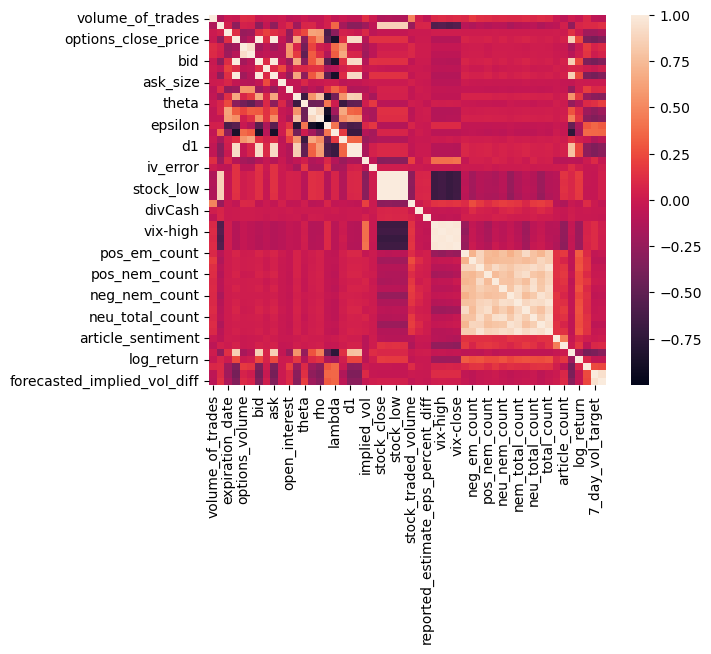

In [25]:
## Seaborn data processing
# df = df.shift()
# sns.heatmap(df.corr('pearson')) ## df_all is data
# processed_df = processed_df.drop(columns={"high", "low", "stock_close", "open", "adjHigh", "adjLow", "adjOpen"})
processed_df = processed_df[processed_df["options_close_price"] != 0]
processed_df["implied_vol"] = processed_df["implied_vol"].shift(-1)
atr = pd.DataFrame()
atr["H-L"] = processed_df["stock_high"] - processed_df["stock_low"]
atr["H-C"] = processed_df["stock_high"] - processed_df["stock_close"]
atr["L-C"] = processed_df["stock_low"] - processed_df["stock_close"]
atr = atr.abs()
column = atr.max(axis=1)
atr["ATR"] = column
# processed_df = processed_df.join(atr, how="left")
# strike_of_zero = processed_df["strike"][processed_df["options_close_price"] == 0] / 1000
# stock_of_zero = processed_df["adjClose"][processed_df["options_close_price"] == 0]
# print(stock_of_zero)
# processed_df["SMA"] = processed_df["stock_close"].rolling(window=30).mean()
# processed_df["SMA"] = processed_df["SMA"].fillna(0)
# typical_price = (processed_df["adjHigh"] + processed_df["adjLow"] + processed_df["adjClose"]) / 3
# raw_money_flow = typical_price * processed_df["stock_volume"]

# Assuming processed_df is your DataFrame
# Filter only numeric columns for correlation
numeric_columns = processed_df.select_dtypes(include=["number"])

# Check if numeric_columns is empty to avoid further errors
if numeric_columns.empty:
    raise ValueError("No numeric columns available for correlation calculation.")

# Plot heatmap with Spearman correlation
sns.heatmap(numeric_columns.corr(method="spearman"))
# sns.pairplot(df)


In [26]:
# correlation matrix
numeric_df = processed_df.select_dtypes(include=['number'])
processed_df = numeric_df
spearman_correlation_matrix = numeric_df.corr(method='spearman')
pearson_correlation_matrix = numeric_df.corr(method='pearson')


In [27]:
# Inspect the correlation matrix

def get_sorted_correlation_pairs(correlation_matrix, variable_name):
    # Flatten the correlation matrix into a long-format DataFrame
    corr_pairs = correlation_matrix.stack().reset_index()
    corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
    # Remove self-correlations (diagonal values where Variable 1 == Variable 2)
    corr_pairs = corr_pairs[corr_pairs['Variable 1'] != corr_pairs['Variable 2']]
    # Sort the correlations by absolute value in descending order
    corr_pairs['Abs Correlation'] = corr_pairs['Correlation'].abs()
    sorted_corr_pairs = corr_pairs.sort_values(by='Abs Correlation', ascending=False)
    # Filter the sorted pairs to only include the specified variable
    filtered_sorted_pairs = sorted_corr_pairs[sorted_corr_pairs['Variable 1'] == variable_name] 
    return filtered_sorted_pairs


In [28]:
spearman_correlation_matrix = processed_df.corr(method='spearman')
pearson_correlation_matrix = processed_df.corr(method='pearson')
processed_df.dropna(subset = ["7_day_vol_target"], inplace=True)

correlation_price = get_sorted_correlation_pairs(spearman_correlation_matrix, '7_day_vol_target')
# correlation_price[correlation_price["Variable 2"].isin(["forecasted_implied_vol_diff", "implied_vol", "7_day_vol_target"])]
# file_name = "total_dataset"
# cur_path = osp.dirname(osp.abspath("__file__"))
# path_to_file = osp.join(cur_path, '{}.pickle'.format(file_name))
# if not osp.isfile(path_to_file):
#     with open(path_to_file, 'wb') as cachedfile:
#         pickle.dump((total_dataset,), cachedfile)
correlation_price

,Variable 1,Variable 2,Correlation,Abs Correlation
2651,7_day_vol_target,forecasted_implied_vol_diff,0.944994,0.944994
2603,7_day_vol_target,options_close_price,-0.403935,0.403935
2606,7_day_vol_target,bid,-0.402408,0.402408
2608,7_day_vol_target,ask,-0.401429,0.401429
2647,7_day_vol_target,previous_price,-0.371277,0.371277
2616,7_day_vol_target,lambda,0.367039,0.367039
2618,7_day_vol_target,d1,-0.357630,0.357630
2619,7_day_vol_target,d2,-0.353082,0.353082
2615,7_day_vol_target,epsilon,0.352137,0.352137
2614,7_day_vol_target,rho,-0.350083,0.350083


In [29]:
print(get_sorted_correlation_pairs(spearman_correlation_matrix, 'implied_vol'))

       Variable 1                          Variable 2  Correlation  \
1072  implied_vol                           vix-close     0.413288   
1071  implied_vol                             vix-low     0.398141   
1070  implied_vol                            vix-high     0.396075   
1069  implied_vol                            vix-open     0.392291   
1062  implied_vol                         stock_close    -0.313861   
1064  implied_vol                           stock_low    -0.309146   
1063  implied_vol                          stock_high    -0.305206   
1065  implied_vol                          stock_open    -0.304705   
1057  implied_vol                               gamma    -0.229480   
1045  implied_vol                               count    -0.216630   
1041  implied_vol                              strike    -0.204310   
1066  implied_vol                 stock_traded_volume     0.196804   
1044  implied_vol                      options_volume    -0.178187   
1059  implied_vol   

In [30]:
print(get_sorted_correlation_pairs(pearson_correlation_matrix, 'implied_vol'))

       Variable 1                          Variable 2  Correlation  \
1091  implied_vol         forecasted_implied_vol_diff    -0.344933   
1052  implied_vol                               theta    -0.317310   
1087  implied_vol                      previous_price     0.228860   
1043  implied_vol                 options_close_price     0.218135   
1048  implied_vol                                 ask     0.216070   
1046  implied_vol                                 bid     0.215192   
1053  implied_vol                                vega    -0.101549   
1040  implied_vol                    volume_of_trades     0.077297   
1041  implied_vol                              strike    -0.057925   
1089  implied_vol                           7_day_vol    -0.055349   
1045  implied_vol                               count    -0.053667   
1054  implied_vol                                 rho    -0.052316   
1066  implied_vol                 stock_traded_volume     0.049949   
1044  implied_vol   

<Axes: >

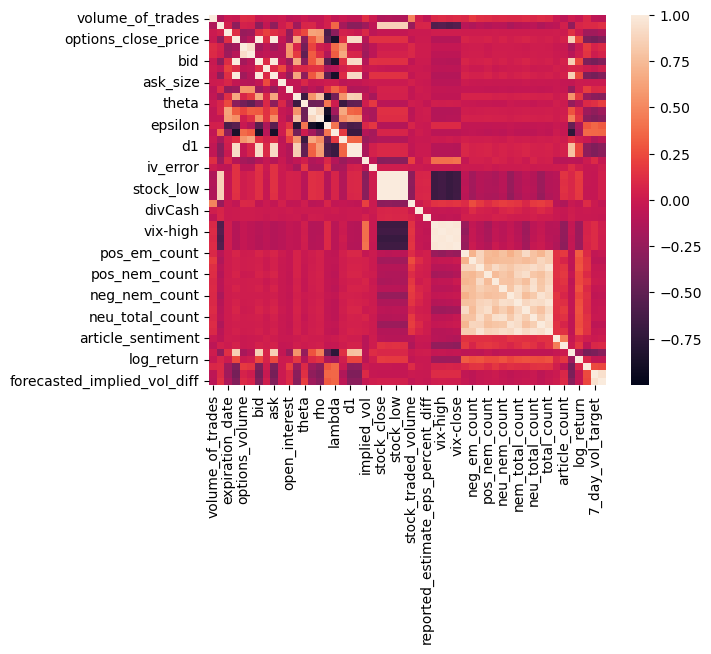

In [31]:
# Visualize the spearman correlation matrix
sns.heatmap(spearman_correlation_matrix)

In [32]:
## RSI - Feature
df_RSI = df.copy()
df_RSI['change'] = df_RSI['stock_close'].diff()
df_RSI['gain'] = np.where(df_RSI['change'] > 0, df_RSI['change'], 0)
df_RSI['loss'] = np.where(df_RSI['change'] < 0, -df_RSI['change'],0)
period = 14 # two week RSI
df_RSI['avg_gain'] = df_RSI['gain'].rolling(window=period).mean()
df_RSI['avg_loss'] = df_RSI['loss'].rolling(window=period).mean()
df_RSI['RS'] = df_RSI['avg_gain'] / df_RSI['avg_loss']
df_RSI['RSI'] = 100 - (100 / (1 + df_RSI['RS']))

## MACD - feature
df.ta.macd(close='stock_close', fast = 12, slow = 26, signal = 9, append = True)



## Add features to processed_df
processed_df['rsi'] = df_RSI['RSI']
processed_df['macd'] = df['MACDh_12_26_9']
sns.heatmap(processed_df.corr(method='spearman'))
processed_df.corr()

AttributeError: 'DataFrame' object has no attribute 'ta'